In [1]:
#load packages
%matplotlib inline
from __future__ import print_function

try:
    xrange
except NameError:
    
    xrange = range

import matplotlib

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler


import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt


import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score

import scipy.stats as stats

import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
#load data
df_all=pd.read_csv('ward-atlas-data-simpleversion.csv')
#creat dataframe for clustering 
df = df_all[['New Code','Borough','Names','Diversity; Ethnic Group 5 groups - 2011 Census; White','Diversity; Ethnic Group 5 groups - 2011 Census; Mixed',
          'Diversity; Ethnic Group 5 groups - 2011 Census; Asian or Asian British',
         'Diversity; Ethnic Group 5 groups - 2011 Census; Black or Black British',
         'Diversity; Ethnic Group 5 groups - 2011 Census; Other',
          'House Prices; Median House Price; 2011','Population and Age; All ages; 2011']
         ]
#rename the columns (orginal is too complex)
cols = df.columns.values
cols[ 3] = 'White'
cols[ 4] = 'Mixed'
cols[5] = 'Asian_or_Asian_British'
cols[6] = 'Black_British'
cols[7] = 'Other'
cols[8] = 'Median_House_Price'
cols[9] ='Population'
df.columns = cols
#data processing - the percent of each race group in total population 
df['White_per'] = df['White']/df['Population']
df['Mixed_per']= df['Mixed']/df['Population']
df['Asian_or_Asian_British_per'] = df['Asian_or_Asian_British']/df['Population']
df['Black_British_per']= df['Black_British']/df['Population']
df['Other_per'] = df['Other']/df['Population']

#data for clustering after processing 
data=df[['Names','Median_House_Price','White_per','Mixed_per','Asian_or_Asian_British_per','Black_British_per','Other_per']]
data=data.set_index('Names')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [3]:
data

,Median_House_Price,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per
Names,,,,,,
City of London,465000.0,0.782380,0.038991,0.126821,0.026039,0.020777
Abbey,177000.0,0.276573,0.044993,0.432164,0.201584,0.028073
Alibon,160000.0,0.695374,0.034601,0.071019,0.181610,0.010036
Becontree,170000.0,0.585360,0.045180,0.173220,0.176582,0.015089
Chadwell Heath,195000.0,0.619859,0.047107,0.155363,0.158650,0.017030
...,...,...,...,...,...,...
Tachbrook,515000.0,0.779272,0.033244,0.092154,0.052921,0.039477
Vincent Square,600000.0,0.706465,0.045937,0.125300,0.072158,0.049740
Warwick,590000.0,0.759113,0.039011,0.099233,0.052547,0.048710


## Data Standarlization

In [4]:
#data standardlization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data1=scaler.transform(data)

In [5]:
#check the data after standarlization 
a=pd.DataFrame(data1)
a['Median_house_price'] =a[0]
a['White_per'] = a[1]
a['Mixed_per']= a[2]
a['Asian_or_Asian_British_per'] = a[3]
a['Black_British_per']= a[4]
a['Other_per'] = a[5]

b=a[['Median_house_price','White_per','Mixed_per','Asian_or_Asian_British_per','Black_British_per','Other_per']]
b

,Median_house_price,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per
0,0.211656,0.804693,0.313008,0.144621,0.038415,0.093724
1,0.034969,0.239475,0.384274,0.530941,0.391273,0.130859
2,0.024540,0.707467,0.260891,0.074020,0.351123,0.039053
3,0.030675,0.584531,0.386496,0.203324,0.341017,0.064770
4,0.046012,0.623082,0.409372,0.180732,0.304971,0.074652
...,...,...,...,...,...,...
620,0.242331,0.801219,0.244770,0.100759,0.092450,0.188908
621,0.294479,0.719861,0.395479,0.142697,0.131117,0.241147
622,0.288344,0.778693,0.313246,0.109716,0.091699,0.235907
623,0.180982,0.459961,0.642111,0.163815,0.282873,0.870886


## Data Distribution

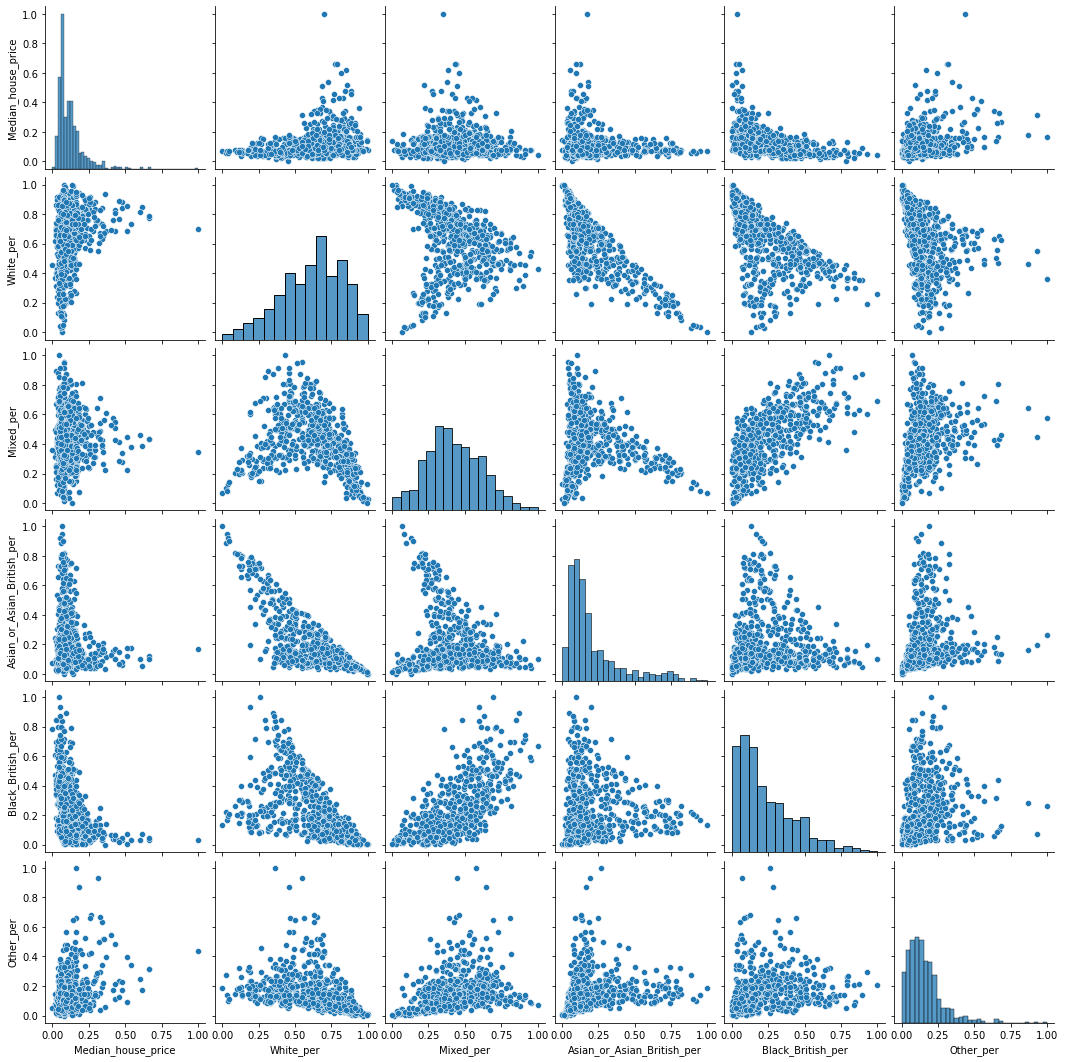

In [6]:
sns.pairplot(b)

In [7]:
#X for later cluster 
X=b

## PCA

### decide how many dimensions we should keep

In [8]:
pca = PCA()
principalComponents = pca.fit_transform(X)

Text(0, 0.5, 'Cumulative explained variance')

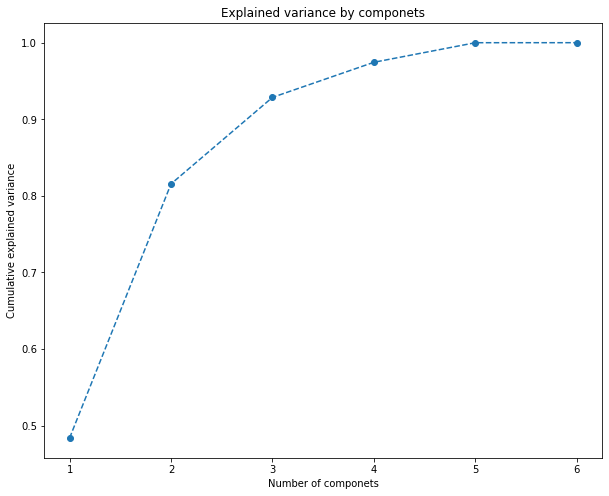

In [10]:
plt.figure(figsize = (10,8))
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained variance by componets')
plt.xlabel('Number of componets')
plt.ylabel('Cumulative explained variance')
#plt.savefig('data/img/pca_explained.png')

#### dimensions of 2 could explain over 80% of data

### so we'll choose 2 as the n_components

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['x', 'y'])
principalDf


,x,y
0,-0.312638,0.055535
1,0.437027,0.267445
2,-0.121959,-0.061294
3,0.049853,-0.013826
4,0.005356,-0.037159
...,...,...
620,-0.309807,0.040626
621,-0.165218,-0.016429
622,-0.265261,0.010889
623,0.298429,-0.157018


In [12]:
#how many percent of data could be explained by PCA first two principles 
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.48383694 0.33178364]
[7.42408663 6.14781798]


In [13]:
print('pca.explained_variance_ratio :',pca.explained_variance_ratio_)
print('total explained data:', sum(pca.explained_variance_ratio_))


pca.explained_variance_ratio : [0.48383694 0.33178364]
total explained data: 0.8156205794212705


<AxesSubplot:xlabel='x', ylabel='y'>

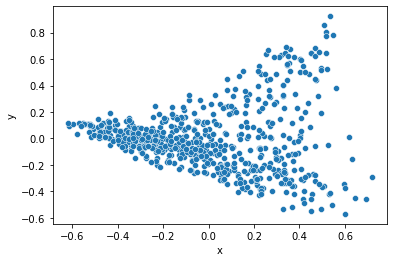

In [15]:
sns.scatterplot(data=principalDf, x="x", y="y")
#plt.savefig('data/img/pca.png')

## K-means 

In [16]:
from sklearn import metrics
#silhoutte Score and elbow 
scores=[]#silhoutte Score
intra_sum_of_square_list = [] #elbow

max_cluster = 20
clusters = range(2,max_cluster)

for k in clusters:
    km = KMeans(n_clusters=k)
    labels=km.fit(principalDf).labels_
    score=metrics.silhouette_score(principalDf,labels)
    scores.append(score) #silhoutte Score
    intra_sum_of_square_list.append(km.inertia_) #elbow


### Finding the best k 

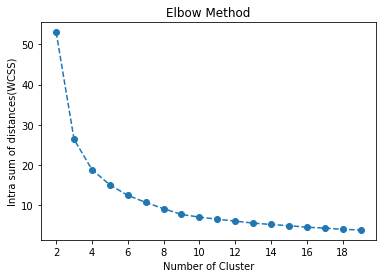

In [17]:
#Elbow
from matplotlib.pyplot import MultipleLocator
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("Elbow Method")
ax.set_xlabel("Number of Cluster")
ax.set_ylabel("Intra sum of distances(WCSS)")
plt.plot(clusters,intra_sum_of_square_list,marker = 'o', linestyle = '--')


x_major_locator = MultipleLocator(2)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

In [18]:
intra_sum_of_square_list

[53.0048969000749,
 26.405251138199713,
 18.90623519953349,
 15.092015796371568,
 12.502867119875388,
 10.755888720489075,
 9.198576611925667,
 7.767656392064021,
 7.106575349040669,
 6.575577585179462,
 6.121507038622771,
 5.617499810839238,
 5.275596205624421,
 4.98041487772297,
 4.595671762287262,
 4.380661723887388,
 4.0624305992956575,
 3.924876424301903]

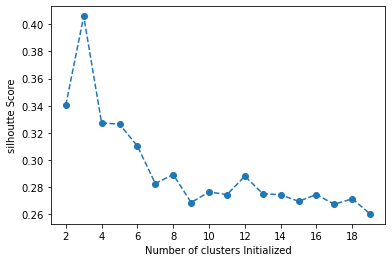

In [19]:
#silhoutte Score 
silhoutte_scores2=[]#silhoutte Score
#intra_sum_of_square_list = [] #elbow
X2 = X

for k in clusters:
    km = KMeans(n_clusters=k)
    labels = km.fit(X2).labels_
    scoress = silhouette_score(X2,labels)
    silhoutte_scores2.append(scoress) #silhoutte Score
    #intra_sum_of_square_list.append(km.inertia_) #elbow
    
plt.plot(clusters, silhoutte_scores2, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters Initialized')
plt.ylabel('silhoutte Score')

x_major_locator = MultipleLocator(2)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)


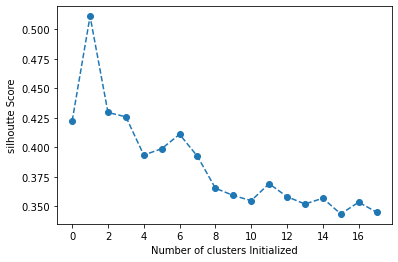

In [21]:

#silhoutte Score
plt.plot(scores, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters Initialized')
plt.ylabel('silhoutte Score')
#plt.savefig('data/img/score.png')

x_major_locator = MultipleLocator(2)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)


In [22]:
round_score = [round(num, 4) for num in scores]
round_score

[0.4225,
 0.5112,
 0.4296,
 0.4259,
 0.3935,
 0.3989,
 0.4111,
 0.3924,
 0.3654,
 0.3592,
 0.3548,
 0.3692,
 0.3582,
 0.352,
 0.3569,
 0.3436,
 0.3535,
 0.3451]

#### Combine two indicators together!

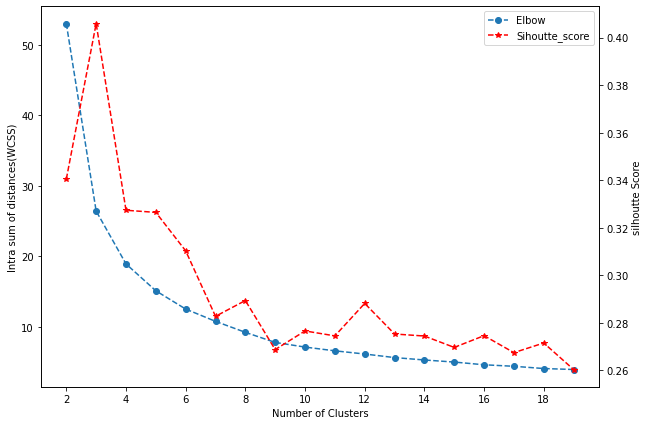

In [24]:
# combine two indicators together!
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()

Elbow, =ax1.plot(clusters,intra_sum_of_square_list, label="Elbow", marker = 'o', linestyle = '--')
Sihoutte_score, =ax2.plot(clusters, silhoutte_scores2,label="Sihoutte_score", color='red', marker = '*', linestyle = '--')

ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Intra sum of distances(WCSS)")
ax2.set_ylabel('silhoutte Score')

x_major_locator = MultipleLocator(2)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(x_major_locator)


#legend
legend = ax1.legend(handles=[Elbow,Sihoutte_score], loc='upper right')

#plt.savefig('data/img/bestK.png')
#legend1 = pyplot.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)

### Conducting K-means

In [25]:
km = KMeans(n_clusters=3,init="k-means++",n_init=10,max_iter=300)
##Init is a sheet argument,max_iter is the max times to update the sheet
km.fit(principalDf)
cluster_labels = km.predict(principalDf)

In [26]:
principalDf['cluster_labels']=cluster_labels
data['cluster_labels']=cluster_labels
df['cluster_labels']=cluster_labels
df['cluster_names'] = str(df['cluster_labels'])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### label for map

In [65]:
cluster_class={0:'O: white_high',1:'1: asian_low',2:'2: asian_high'}
cluster_class

{0: 'O: white_high', 1: '1: asian_low', 2: '2: asian_high'}

In [66]:
df['cluster_names'] = df['cluster_labels'].map(cluster_class)
df

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,New Code,Borough,Names,White,Mixed,Asian_or_Asian_British,Black_British,Other,Median_House_Price,Population,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per,cluster_labels,cluster_names
0,E09000001,City of London,City of London,5799,289,940,193,154,465000.0,7412,0.782380,0.038991,0.126821,0.026039,0.020777,0,O: white_high
1,E05000026,Barking and Dagenham,Abbey,3596,585,5619,2621,365,177000.0,13002,0.276573,0.044993,0.432164,0.201584,0.028073,2,2: asian_high
2,E05000027,Barking and Dagenham,Alibon,7275,362,743,1900,105,160000.0,10462,0.695374,0.034601,0.071019,0.181610,0.010036,0,O: white_high
3,E05000028,Barking and Dagenham,Becontree,6789,524,2009,2048,175,170000.0,11598,0.585360,0.045180,0.173220,0.176582,0.015089,1,1: asian_low
4,E05000029,Barking and Dagenham,Chadwell Heath,6224,473,1560,1593,171,195000.0,10041,0.619859,0.047107,0.155363,0.158650,0.017030,0,O: white_high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000645,Westminster,Tachbrook,6376,272,754,433,323,515000.0,8182,0.779272,0.033244,0.092154,0.052921,0.039477,0,O: white_high
621,E05000646,Westminster,Vincent Square,7059,459,1252,721,497,600000.0,9992,0.706465,0.045937,0.125300,0.072158,0.049740,0,O: white_high
622,E05000647,Westminster,Warwick,7122,366,931,493,457,590000.0,9382,0.759113,0.039011,0.099233,0.052547,0.048710,0,O: white_high
623,E05000648,Westminster,Westbourne,6024,848,1805,1877,2205,415000.0,12712,0.473883,0.066709,0.141992,0.147656,0.173458,1,1: asian_low


In [67]:
principalDf

,x,y,cluster_labels
0,-0.312638,0.055535,0
1,0.437027,0.267445,2
2,-0.121959,-0.061294,0
3,0.049853,-0.013826,1
4,0.005356,-0.037159,0
...,...,...,...
620,-0.309807,0.040626,0
621,-0.165218,-0.016429,0
622,-0.265261,0.010889,0
623,0.298429,-0.157018,1


In [68]:
x=principalDf.x
y=principalDf.y

<AxesSubplot:xlabel='x', ylabel='y'>

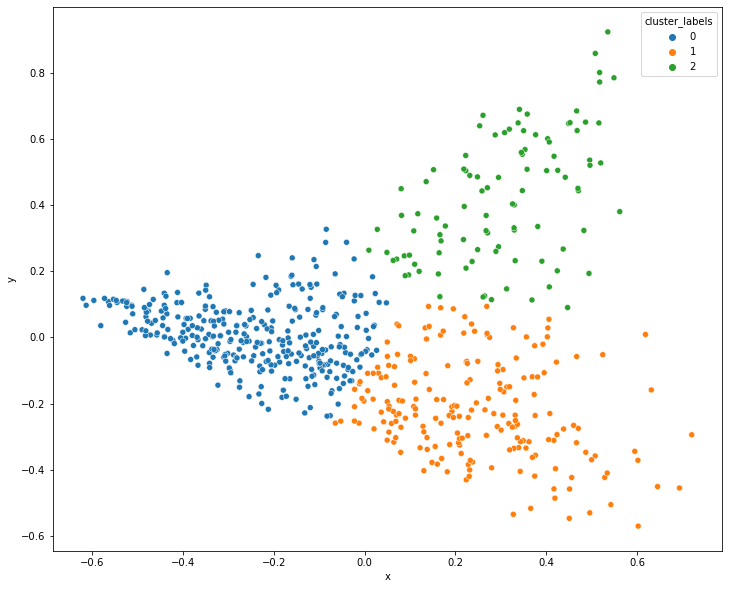

In [69]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
sns.color_palette("Spectral", as_cmap=True)
sns.scatterplot(data=principalDf, x="x", y="y",hue="cluster_labels",palette='tab10')
#plt.savefig('data/img/cluster_visualization.png')

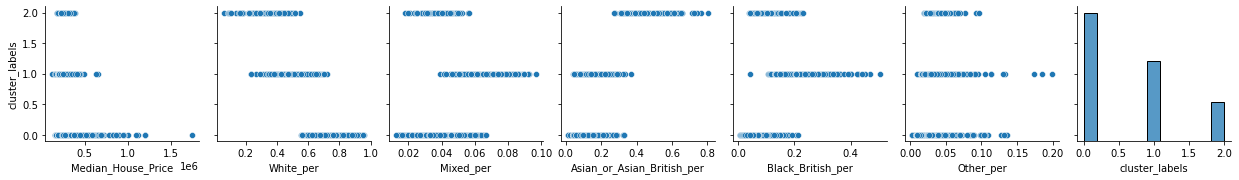

In [70]:

sns.pairplot(data, y_vars='cluster_labels')
#plt.savefig('data/img/cluster_result.png',dpi=300)

## Back to real World

In [71]:
# back to real world 
df.head(1)

,New Code,Borough,Names,White,Mixed,Asian_or_Asian_British,Black_British,Other,Median_House_Price,Population,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per,cluster_labels,cluster_names
0,E09000001,City of London,City of London,5799,289,940,193,154,465000.0,7412,0.78238,0.038991,0.126821,0.026039,0.020777,0,O: white_high


In [72]:
#load ward data
ward = gpd.read_file('infuse_ward_lyr_2011/infuse_ward_lyr_2011.shp')


In [73]:
ward.head(5)

,geo_code,geo_label,geo_labelw,label,name,geometry
0,95EE06,Dunloy,None,N9200000295EE06,Dunloy,"POLYGON ((116040.350 575158.504, 116038.826 57..."
1,E05000251,Askew,None,E92000001E05000251,Askew,"POLYGON ((521826.802 179864.164, 521830.354 17..."
2,E05003736,Wool,None,E92000001E05003736,Wool,"POLYGON ((382733.594 86010.638, 382742.975 860..."
3,95JJ19,Strand,None,N9200000295JJ19,Strand,"POLYGON ((99266.648 596876.298, 99266.482 5968..."
4,E05003384,Sandiacre South,None,E92000001E05003384,Sandiacre South,"POLYGON ((447050.608 335587.054, 447050.469 33..."


In [74]:
joined = ward.merge(df,left_on = 'geo_code', right_on ='New Code')
joined.head(1)

,geo_code,geo_label,geo_labelw,label,name,geometry,New Code,Borough,Names,White,...,Other,Median_House_Price,Population,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per,cluster_labels,cluster_names
0,E05000251,Askew,None,E92000001E05000251,Askew,"POLYGON ((521826.802 179864.164, 521830.354 17...",E05000251,Hammersmith and Fulham,Askew,8920,...,779,360000.0,14162,0.629855,0.064821,0.090312,0.159864,0.055006,1,1: asian_low


In [75]:
joined.head()

,geo_code,geo_label,geo_labelw,label,name,geometry,New Code,Borough,Names,White,...,Other,Median_House_Price,Population,White_per,Mixed_per,Asian_or_Asian_British_per,Black_British_per,Other_per,cluster_labels,cluster_names
0,E05000251,Askew,None,E92000001E05000251,Askew,"POLYGON ((521826.802 179864.164, 521830.354 17...",E05000251,Hammersmith and Fulham,Askew,8920,...,779,360000.0,14162,0.629855,0.064821,0.090312,0.159864,0.055006,1,1: asian_low
1,E05000232,Cazenove,None,E92000001E05000232,Cazenove,"POLYGON ((533654.384 186936.977, 533654.727 18...",E05000232,Hackney,Cazenove,7594,...,924,292000.0,13472,0.563688,0.048768,0.137767,0.175252,0.068587,1,1: asian_low
2,E05000605,Leytonstone,None,E92000001E05000605,Leytonstone,"POLYGON ((538967.707 187911.084, 538978.871 18...",E05000605,Waltham Forest,Leytonstone,6751,...,533,249997.5,12993,0.519587,0.054568,0.244593,0.131455,0.041022,1,1: asian_low
3,E05000063,Woodhouse,None,E92000001E05000063,Woodhouse,"POLYGON ((526331.163 192341.020, 526330.447 19...",E05000063,Barnet,Woodhouse,10966,...,863,280000.0,17625,0.622184,0.054809,0.209362,0.061844,0.048965,0,O: white_high
4,E05000449,New Cross,None,E92000001E05000449,New Cross,"POLYGON ((535270.209 177501.208, 535270.450 17...",E05000449,Lewisham,New Cross,6342,...,457,218500.0,15870,0.399622,0.069124,0.131695,0.363579,0.028796,1,1: asian_low


In [76]:
# find the code for city of london in 2011
c1= ward[ward['geo_code'] =='E36007054']
c2= ward[ward['geo_code'] =='E05000001']
c3= ward[ward['geo_code'] =='E05000015']
c4=ward[ward['geo_code'] =='E36007052']
city_of_london = c1.append(c2).append(c3).append(c4)
#city_of_london.plot()


(500648.62695, 564876.90205, 153596.64335, 203188.04565000001)

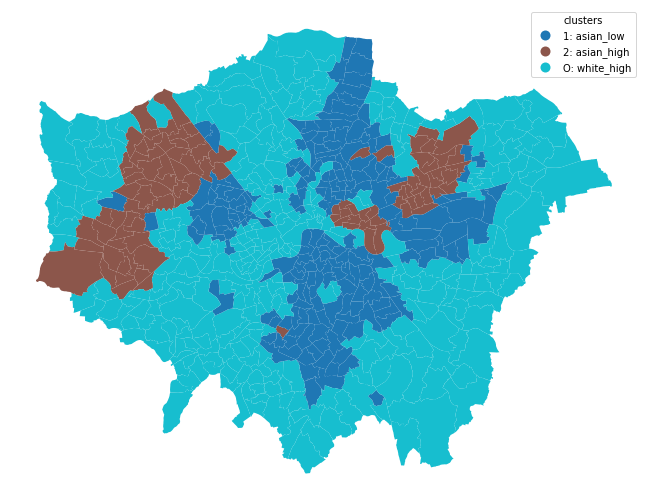

In [77]:
fig, ax = plt.subplots(1,1, figsize=(15,9))
joined.plot(ax=ax, column='cluster_names',legend=True)


ax.get_legend().set_title("clusters")  #set the legend title


city_of_london.plot(ax=ax,color='#17becf')
ax.axis('off') #don't plot the axes (bounding box)
#plt.savefig('yuning/cluster_map.png')


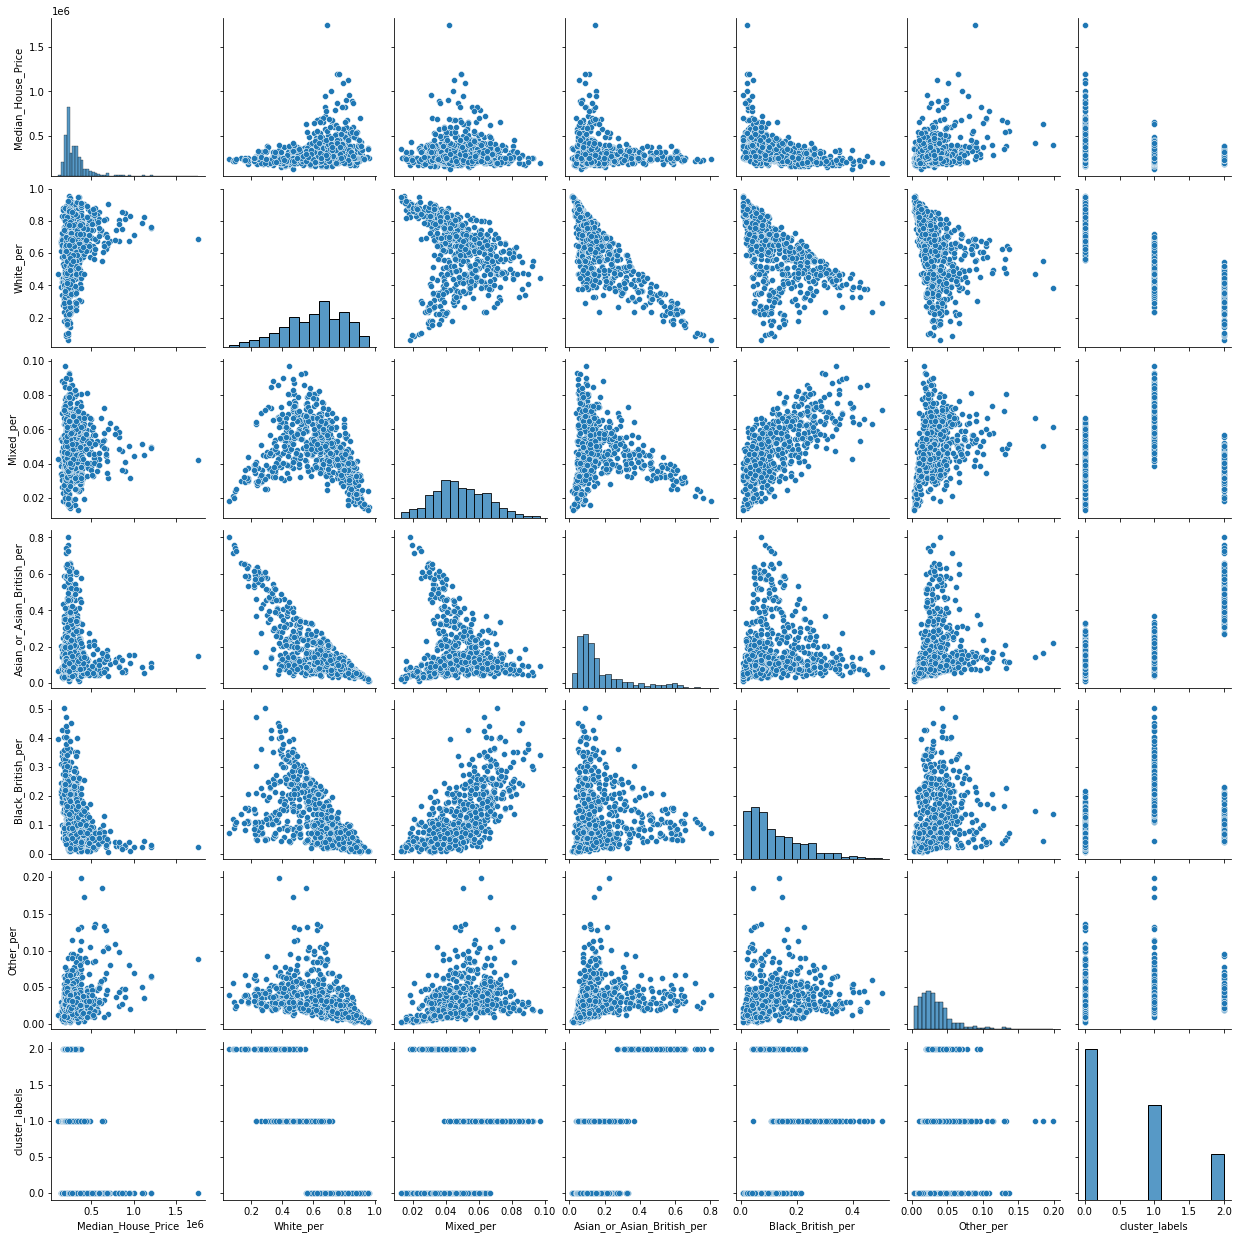

In [78]:
sns.pairplot(data)

In [ ]:
# following 
# mapping visualization - done
# define the clusters - done 
# score and elbows refine - done 